In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim
import optimizer as opt

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=False), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=False), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[12, 2, 4, 9, 13, 8, 2, 3, 10, 4]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h17, cards=[9, 8], doubled=False, drawn=False),
  Hand(score=h17, cards=[2, 9, 4, 2], doubled=False, drawn=True),
  <HandOutcome.PUSH: 0>),
 ('strat_nobust',
  Hand(score=h17, cards=[9, 8], doubled=False, drawn=False),
  Hand(score=h17, cards=[2, 9, 4, 2], doubled=False, drawn=True),
  <HandOutcome.PUSH: 0>)]

## Aggregate and summarize the data from the simulations

In [19]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [3, 8],
  'dealer_card': 12,
  'hand_end': [3, 8, 12],
  'dealer_hand': [12, 4, 4],
  'outcome': <HandOutcome.WIN: 1>},
 {'strategy': 'strat_dealer',
  'hand_start': [3, 8],
  'dealer_card': 12,
  'hand_end': [3, 8, 12],
  'dealer_hand': [12, 4, 4],
  'outcome': <HandOutcome.WIN: 1>}]

In [20]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [21]:
def strat_simple_func(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple_func.name = 'simple'

strat_simple = bj.Strategy_wrapper(strat_simple_func)
sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card          hand_end     dealer_hand  \
 0   simple     [8, 2]           11        [8, 2, 11]        [11, 13]   
 1   simple    [6, 13]            5           [6, 13]       [5, 7, 9]   
 2   simple     [4, 7]            7         [4, 7, 1]      [7, 2, 11]   
 3   simple     [5, 2]            8        [5, 2, 11]       [8, 2, 9]   
 4   simple     [4, 1]           12  [4, 1, 2, 9, 13]      [12, 5, 3]   
 5   simple   [12, 10]            7          [12, 10]       [7, 6, 5]   
 6   simple    [5, 11]           13        [5, 11, 7]      [13, 5, 4]   
 7   simple     [3, 8]            9         [3, 8, 7]    [9, 3, 3, 9]   
 8   simple     [4, 4]           11      [4, 4, 7, 3]  [11, 5, 1, 10]   
 9   simple   [10, 10]           13          [10, 10]      [13, 6, 6]   
 
                    outcome  outcome_value outcome_name  
 0         HandOutcome.PUSH            0.0         PUSH  
 1         HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.LOSE_

In [22]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

In [25]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h22, cards=[5, 7, 13], doubled=False, drawn=True),
  Hand(score=h19, cards=[2, 6, 3, 8], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False),
  Hand(score=h19, cards=[2, 6, 3, 8], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h19, cards=[5, 7, 7], doubled=True, drawn=True),
  Hand(score=h19, cards=[2, 6, 3, 8], doubled=False, drawn=True),
  <HandOutcome.PUSH: 0>)]

In [27]:


sims = sim.run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5894  469     0       3637      -0.4514
<Action.HIT: 2>     6022           0  654  3324          0      -0.2698
<Action.STAND: 1>   6244           0    0  3756          0      -0.2488

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

In [30]:
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6391    0     0       3609      -0.5564
<Action.HIT: 2>     5343           0  827  3830          0      -0.1513
<Action.STAND: 1>   6391           0    0  3609          0      -0.2782
simple              5306           0  818  3876          0      -0.1430

In [31]:
sim.summarize_totals(sim.run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6072  670  3258      -0.2814
strat_cond    6298    0  3702      -0.2596

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5750    0     0       4250      -0.3000
<Action.HIT: 2>     4833           0  268  4899          0       0.0066
<Action.STAND: 1>   5750           0    0  4250          0      -0.1500
simple              5750           0    0  4250          0      -0.1500

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3246  655     0       6099       0.5706
<Action.HIT: 2>     3205           0  645  6150          0       0.2945
<Action.STAND: 1>   5790           0    0  4210          0      -0.1580
simple              3195           0  646  6159          0       0.2964

In [34]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3184  688     0       6128       0.5888
 <Action.HIT: 2>     3206           0  685  6109          0       0.2903
 <Action.STAND: 1>   5737           0    0  4263          0      -0.1474)

In [35]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         155    8    0         37       -1.180
 <Action.HIT: 2>     157           0    7   36          0       -0.605
 <Action.STAND: 1>    61           0   30  109          0        0.240)

In [36]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          64   14    0        122         0.58
 <Action.HIT: 2>      60           0   16  124          0         0.32
 <Action.STAND: 1>     0           0   18  182          0         0.91)

In [37]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 3>': 0.55,
 '<Action.HIT: 2>': 0.355,
 '<Action.STAND: 1>': -0.11,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 3>,
 'winning_act_outcome': 0.55}

In [38]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         843   25    0        132       -1.422
 <Action.HIT: 2>     858           0   18  124          0       -0.734
 <Action.STAND: 1>   592           0  128  280          0       -0.312)

In [39]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h09     s11                    -0.5            0.225              -0.50   
        h02                     0.5            0.300              -0.10   
        h03                     0.6            0.200              -0.30   
        h04                     0.2            0.250              -0.10   
        h05                     0.4            0.375              -0.10   
...                             ...              ...                ...   
s21     h06                     0.1            0.050               0.85   
        h07                     0.2            0.300               0.90   
        h08                     0.2            0.050               0.85   
        h09                     0.9            0.500               0.95   
        h10                    -0.5           -0.175               0.75   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h09     s11         Action.HIT                0.225  
        h02      Action.DOUBLE                0.500  
        h03      Action.DOUBLE                0.600  
        h04         Action.HIT                0.250  
        h05      Action.DOUBLE                0.400  
...                        ...                  ...  
s21     h06       Action.STAND                0.850  
        h07       Action.STAND                0.900  
        h08       Action.STAND                0.850  
        h09       Action.STAND                0.950  
        h10       Action.STAND                0.750  

[250 rows x 5 columns]

In [40]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

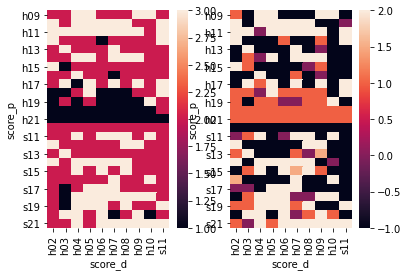

In [41]:


%prun -s cumulative opt.run_iteration(1, strat_simple, None)

In [42]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = opt.gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(   strategy hand_start  dealer_card         hand_end    dealer_hand  \
 0    simple    [12, 7]           12          [12, 7]       [12, 10]   
 1  memoized    [12, 7]           12          [12, 7]       [12, 10]   
 2    simple    [4, 10]            1       [4, 10, 9]  [1, 4, 13, 3]   
 3  memoized    [4, 10]            1      [4, 10, 13]  [1, 4, 13, 3]   
 4    simple    [10, 7]            6          [10, 7]      [6, 4, 1]   
 5  memoized    [10, 7]            6          [10, 7]      [6, 4, 1]   
 6    simple     [1, 4]            2  [1, 4, 6, 2, 9]     [2, 7, 13]   
 7  memoized     [1, 4]            2    [1, 4, 13, 9]     [2, 7, 13]   
 8    simple    [4, 13]           13       [4, 13, 9]     [13, 6, 1]   
 9  memoized    [4, 13]           13       [4, 13, 8]     [13, 6, 1]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3

Starting iteration 0
Starting iteration 1
('h09', 'h02') Action.DOUBLE Action.HIT
('h09', 'h03') Action.HIT Action.DOUBLE
('h09', 'h06') Action.DOUBLE Action.HIT
('h09', 'h08') Action.HIT Action.DOUBLE
('h10', 'h03') Action.HIT Action.DOUBLE
('h10', 'h08') Action.DOUBLE Action.HIT
('h10', 'h10') Action.DOUBLE Action.HIT
('h11', 'h04') Action.DOUBLE Action.HIT
('h11', 'h08') Action.HIT Action.DOUBLE
('h11', 'h09') Action.HIT Action.DOUBLE
('h12', 'h03') Action.STAND Action.DOUBLE
('h12', 'h05') Action.HIT Action.STAND
('h12', 'h06') Action.STAND Action.HIT
('h13', 'h02') Action.STAND Action.HIT
('h13', 'h03') Action.STAND Action.DOUBLE
('h13', 'h04') Action.HIT Action.STAND
('h13', 'h06') Action.STAND Action.HIT
('h13', 'h10') Action.STAND Action.HIT
('h14', 'h02') Action.STAND Action.DOUBLE
('h14', 'h05') Action.HIT Action.STAND
('h14', 'h09') Action.HIT Action.STAND
('h14', 'h10') Action.HIT Action.STAND
('h15', 's11') Action.HIT Action.STAND
('h15', 'h07') Action.STAND Action.HIT
('h

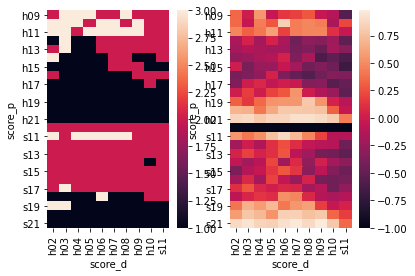

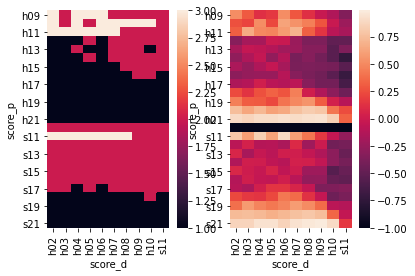

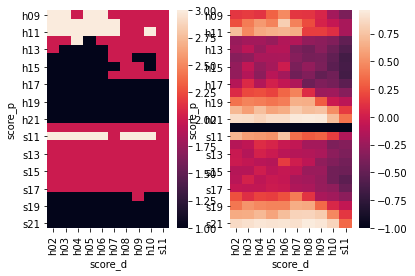

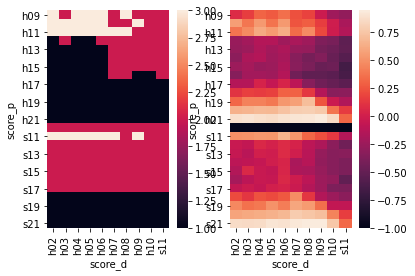

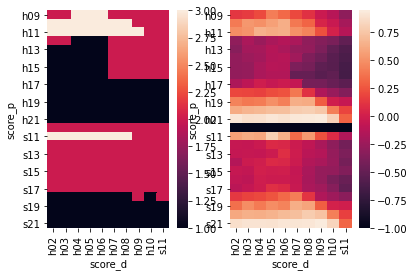

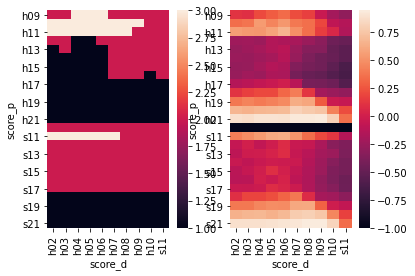

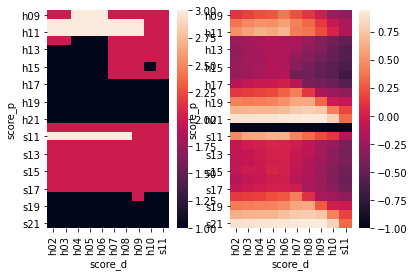

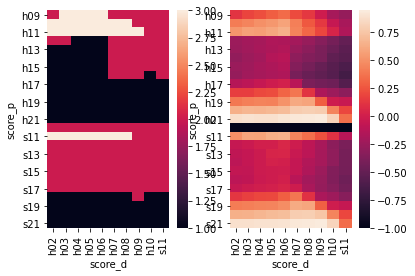

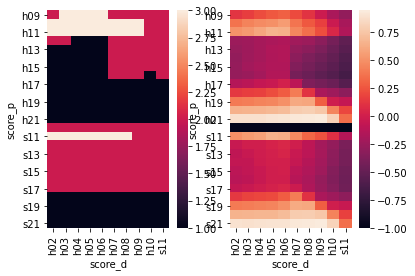

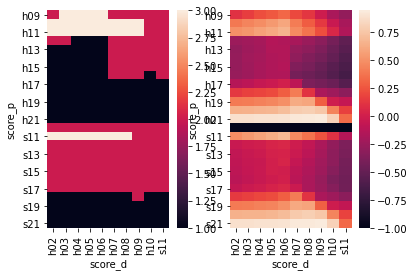

In [43]:


strategies = opt.derive_iterative_strategies(strat_simple, 10)
strategies

In [47]:
with open('strategies.pickle', 'wb') as handle:
    pickle.dump(strategies, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card    hand_end    dealer_hand  \
 0   simple     [3, 8]            2  [3, 8, 13]  [2, 2, 5, 12]   
 1  iter(1)     [3, 8]            2   [3, 8, 1]  [2, 2, 5, 12]   
 2  iter(2)     [3, 8]            2   [3, 8, 1]  [2, 2, 5, 12]   
 3  iter(3)     [3, 8]            2  [3, 8, 10]  [2, 2, 5, 12]   
 4  iter(4)     [3, 8]            2  [3, 8, 13]  [2, 2, 5, 12]   
 5  iter(5)     [3, 8]            2   [3, 8, 3]  [2, 2, 5, 12]   
 6  iter(6)     [3, 8]            2   [3, 8, 4]  [2, 2, 5, 12]   
 7  iter(7)     [3, 8]            2   [3, 8, 9]  [2, 2, 5, 12]   
 8  iter(8)     [3, 8]            2  [3, 8, 13]  [2, 2, 5, 12]   
 9  iter(9)     [3, 8]            2   [3, 8, 2]  [2, 2, 5, 12]   
 
                    outcome  outcome_value outcome_name  
 0   HandOutcome.WIN_DOUBLE            2.0   WIN_DOUBLE  
 1  HandOutcome.LOSE_DOUBLE           -2.0  LOSE_DOUBLE  
 2  HandOutcome.LOSE_DOUBLE           -2.0  LOSE_DOUBLE  
 3   HandOutcome.WIN_DOUBLE            2